# XGBoost Exoplanet Classification - CLEAN VERSION

This notebook performs binary classification with XGBoost using the unified exoplanet dataset:
- **Data Leakage Prevention**: Realistic performance via star-based split
- Train the model on labeled data (label: 0=false positive, 1=confirmed planet)
- Predict and classify candidates
- Save final results as CSV


In [ ]:
# 1. Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries loaded!")
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")


✅ Kütüphaneler yüklendi!
Pandas version: 2.3.3
XGBoost version: 3.0.5


## 1. Data Loading and Inspection


In [ ]:
# Load training data
print("📊 Loading training data...")
train_df = pd.read_csv('training_data.csv')
print(f"Training data shape: {train_df.shape}")
print(f"\nLabel distribution:")
print(train_df['label'].value_counts())
print(f"\nLabel distribution (%):")
print(train_df['label'].value_counts(normalize=True) * 100)


📊 Training data yükleniyor...
Training data shape: (12194, 34)

Label dağılımı:
label
0    6449
1    5745
Name: count, dtype: int64

Label dağılımı yüzdesi:
label
0    52.886666
1    47.113334
Name: proportion, dtype: float64


In [ ]:
# Load candidate data
print("\n📊 Loading candidate data...")
candidate_df = pd.read_csv('candidate_data.csv')
print(f"Candidate data shape: {candidate_df.shape}")
print(f"\nCandidate label distribution:")
print(candidate_df['label'].value_counts())



📊 Candidate data yükleniyor...
Candidate data shape: (9077, 34)

Candidate label dağılımı:
label
-1    9077
Name: count, dtype: int64


In [ ]:
# Data leakage check - CRITICAL!
print("\n🔍 DATA LEAKAGE CHECK")
train_stars = set(train_df['star_id'].unique())
candidate_stars = set(candidate_df['star_id'].unique())
common_stars = train_stars.intersection(candidate_stars)

print(f"Unique stars in training set: {len(train_stars)}")
print(f"Unique stars in candidate set: {len(candidate_stars)}")
print(f"Common stars: {len(common_stars)}")

if len(common_stars) > 0:
    print(f"⚠️  WARNING: {len(common_stars)} common stars! This may cause data leakage.")
    print("First 10 common star_id:", list(common_stars)[:10])
    
    # Data leakage fix: remove common stars from candidate set
    print(f"\n🔧 DATA LEAKAGE FIX")
    print(f"Removing common stars from candidate set...")
    
    # Remove common stars from candidate set
    candidate_df_clean = candidate_df[~candidate_df['star_id'].isin(common_stars)].copy()
    
    print(f"Previous candidate set size: {candidate_df.shape}")
    print(f"Fixed candidate set size: {candidate_df_clean.shape}")
    print(f"Removed candidates: {candidate_df.shape[0] - candidate_df_clean.shape[0]}")
    
    # Use the fixed candidate set
    candidate_df = candidate_df_clean
    
    # Re-check
    candidate_stars_clean = set(candidate_df['star_id'].unique())
    common_stars_clean = train_stars.intersection(candidate_stars_clean)
    print(f"\nCommon stars after fix: {len(common_stars_clean)}")
    
    if len(common_stars_clean) == 0:
        print("✅ Data leakage fixed! No common stars remain.")
    else:
        print("⚠️  Common stars still exist!")
else:
    print("✅ No common stars between training and candidate sets.")



🔍 DATA LEAKAGE KONTROLÜ
Training set'teki unique star sayısı: 9173
Candidate set'teki unique star sayısı: 8357
Ortak star sayısı: 349
⚠️  UYARI: 349 ortak yıldız var! Bu data leakage'a neden olabilir.
İlk 10 ortak star_id: ['288631580', '6276791', '11296437', '7767162', 'EPIC 220256496', '8709688', '5526717', '2861126', '9347899', '5978559']

🔧 DATA LEAKAGE DÜZELTMESİ
Ortak yıldızları candidate setinden çıkarılıyor...
Önceki candidate set boyutu: (9077, 34)
Düzeltilmiş candidate set boyutu: (8671, 34)
Çıkarılan candidate sayısı: 406

Düzeltme sonrası ortak star sayısı: 0
✅ Data leakage düzeltildi! Artık ortak yıldız yok.


## 1.1. Data Quality Check


In [ ]:
# Data quality check - Training data
print("🔍 TRAINING DATA QUALITY CHECK")
print(f"Training data shape: {train_df.shape}")
print(f"Empty rows: {train_df.isnull().all(axis=1).sum()}")
print(f"Duplicate rows: {train_df.duplicated().sum()}")
print(f"Empty strings: {(train_df == '').sum().sum()}")

# Missing values check
print(f"\n📊 MISSING VALUES ANALYSIS")
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

print("Top columns with missing values:")
print(missing_df[missing_df['Missing_Count'] > 0].head(10))

# Infinite values check
print(f"\n♾️  INFINITE VALUES CHECK")
inf_count = np.isinf(train_df.select_dtypes(include=[np.number])).sum().sum()
print(f"Infinite values: {inf_count}")

if inf_count > 0:
    print("Columns with infinite values:")
    inf_cols = train_df.select_dtypes(include=[np.number])
    for col in inf_cols.columns:
        inf_count_col = np.isinf(inf_cols[col]).sum()
        if inf_count_col > 0:
            print(f"  - {col}: {inf_count_col} infinite values")

# Data types
print(f"\n📋 DATA TYPES")
print(train_df.dtypes.value_counts())


🔍 TRAINING DATA KALİTE KONTROLÜ
Training data shape: (12194, 34)
Boş satır sayısı: 0
Duplicate satır sayısı: 1
Empty string sayısı: 0

📊 MISSING VALUES ANALİZİ
En çok missing value olan kolonlar:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percent]
Index: []

♾️  SONSUZ DEĞERLER KONTROLÜ
Sonsuz değer sayısı: 0

📋 VERİ TİPLERİ
float64    24
int64       7
object      3
Name: count, dtype: int64


In [ ]:
# Data cleaning steps
print("\n🧹 DATA CLEANING STEPS")

# 1. Drop empty rows
print("1. Dropping empty rows...")
train_df_clean = train_df.dropna(how='all').copy()
candidate_df_clean = candidate_df.dropna(how='all').copy()

print(f"Training - Before: {train_df.shape}, After: {train_df_clean.shape}")
print(f"Candidate - Before: {candidate_df.shape}, After: {candidate_df_clean.shape}")

# 2. Remove duplicate rows
print("\n2. Removing duplicate rows...")
train_df_clean = train_df_clean.drop_duplicates().copy()
candidate_df_clean = candidate_df_clean.drop_duplicates().copy()

print(f"Training - Before: {train_df.shape}, After: {train_df_clean.shape}")
print(f"Candidate - Before: {candidate_df.shape}, After: {candidate_df_clean.shape}")

# 3. Replace empty strings with NaN
print("\n3. Cleaning empty strings...")
train_df_clean = train_df_clean.replace('', np.nan)
candidate_df_clean = candidate_df_clean.replace('', np.nan)

# 4. Replace infinite values with NaN
print("\n4. Cleaning infinite values...")
numeric_cols_train = train_df_clean.select_dtypes(include=[np.number]).columns
numeric_cols_cand = candidate_df_clean.select_dtypes(include=[np.number]).columns

train_df_clean[numeric_cols_train] = train_df_clean[numeric_cols_train].replace([np.inf, -np.inf], np.nan)
candidate_df_clean[numeric_cols_cand] = candidate_df_clean[numeric_cols_cand].replace([np.inf, -np.inf], np.nan)

# Use cleaned data
train_df = train_df_clean
candidate_df = candidate_df_clean

print(f"\n✅ Data cleaning completed!")
print(f"Final training data shape: {train_df.shape}")
print(f"Final candidate data shape: {candidate_df.shape}")



🧹 VERİ TEMİZLEME İŞLEMLERİ
1. Boş satırları çıkarılıyor...
Training - Önceki: (12194, 34), Sonraki: (12194, 34)
Candidate - Önceki: (8671, 34), Sonraki: (8671, 34)

2. Duplicate satırları çıkarılıyor...
Training - Önceki: (12194, 34), Sonraki: (12193, 34)
Candidate - Önceki: (8671, 34), Sonraki: (8671, 34)

3. Empty string'leri temizleniyor...

4. Sonsuz değerler temizleniyor...

✅ Veri temizleme tamamlandı!
Final training data shape: (12193, 34)
Final candidate data shape: (8671, 34)


## 2. Feature Engineering ve Data Preprocessing


In [ ]:
# Common column check
print("\n🔍 COMMON COLUMN CHECK")
train_cols = set(train_df.columns)
candidate_cols = set(candidate_df.columns)
common_cols = train_cols.intersection(candidate_cols)

print(f"Training data column count: {len(train_cols)}")
print(f"Candidate data column count: {len(candidate_cols)}")
print(f"Common column count: {len(common_cols)}")

if len(common_cols) == len(train_cols) and len(common_cols) == len(candidate_cols):
    print("✅ All columns are common - structures are compatible!")
else:
    print("⚠️  Column mismatch detected!")
    train_only = train_cols - candidate_cols
    candidate_only = candidate_cols - train_cols
    
    if train_only:
        print(f"Columns only in training: {list(train_only)}")
    if candidate_only:
        print(f"Columns only in candidate: {list(candidate_only)}")

print(f"\nCommon columns: {sorted(list(common_cols))}")



🔍 ORTAK SÜTUN KONTROLÜ
Training data sütun sayısı: 34
Candidate data sütun sayısı: 34
Ortak sütun sayısı: 34
✅ Tüm sütunlar ortak - veri yapısı uyumlu!

Ortak sütunlar: ['dec_deg', 'dor_ratio', 'duration_hours', 'ecc', 'feh_dex', 'fp_flag_co', 'fp_flag_ec', 'fp_flag_nt', 'fp_flag_ss', 'impact_param', 'insolation', 'is_candidate', 'label', 'logg_cgs', 'mag_kepler', 'mag_tess', 'mass_solar', 'num_transits', 'period_days', 'planet_id', 'ra_deg', 'radius_solar', 'ror_ratio', 'rp_re', 'snr', 'source_dataset', 'star_id', 'stellar_distance', 'stellar_pmdec', 'stellar_pmra', 't0_bjd', 'teff_k', 'teq_k', 'transit_depth_ppm']


In [ ]:
def preprocess_data(df, is_training=True):
    """
    Data preprocessing function
    """
    df_processed = df.copy()
    
    # Encode categorical variables
    if 'source_dataset' in df_processed.columns:
        le = LabelEncoder()
        df_processed['source_dataset_encoded'] = le.fit_transform(df_processed['source_dataset'])
    
    # Select numeric features
    numeric_features = [
        'ra_deg', 'dec_deg', 'period_days', 't0_bjd', 'transit_depth_ppm',
        'duration_hours', 'impact_param', 'ecc', 'snr', 'rp_re', 'teq_k',
        'insolation', 'teff_k', 'logg_cgs', 'feh_dex', 'mass_solar', 'radius_solar',
        'mag_kepler', 'num_transits', 'ror_ratio', 'dor_ratio', 'fp_flag_nt',
        'fp_flag_ss', 'fp_flag_co', 'fp_flag_ec', 'mag_tess', 'stellar_pmra',
        'stellar_pmdec', 'stellar_distance'
    ]
    
    # Select only existing columns
    available_features = [col for col in numeric_features if col in df_processed.columns]
    
    # Add source dataset encoded
    if 'source_dataset_encoded' in df_processed.columns:
        available_features.append('source_dataset_encoded')
    
    # Build feature matrix
    X = df_processed[available_features].copy()
    
    # Fill missing values with median
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64']:
            X[col] = X[col].fillna(X[col].median())
    
    # Check and fix infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64']:
            X[col] = X[col].fillna(X[col].median())
    
    if is_training:
        # Training data için label'ı binary yap (0: false positive, 1: confirmed planet)
        y = (df_processed['label'] == 1).astype(int)
        return X, y, available_features
    else:
        # Candidate data için sadece features döndür
        return X, available_features

print("✅ Preprocessing function defined!")


✅ Preprocessing fonksiyonu tanımlandı!


In [ ]:
# Training data preprocessing
print("🔧 Training data preprocessing...")
X_train, y_train, feature_names = preprocess_data(train_df, is_training=True)

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Feature names: {len(feature_names)} features")
print(f"\nTraining label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTraining label distribution (%):")
print(pd.Series(y_train).value_counts(normalize=True) * 100)


🔧 Training data preprocessing...
Training features shape: (12193, 30)
Training labels shape: (12193,)
Feature names: 30 features

Training label dağılımı:
label
0    6449
1    5744
Name: count, dtype: int64

Training label dağılımı yüzdesi:
label
0    52.891003
1    47.108997
Name: proportion, dtype: float64


In [ ]:
# Candidate data preprocessing
print("\n🔧 Candidate data preprocessing...")
X_candidates, candidate_feature_names = preprocess_data(candidate_df, is_training=False)

print(f"Candidate features shape: {X_candidates.shape}")
print(f"Feature names match: {feature_names == candidate_feature_names}")

# Ensure feature names match
if feature_names != candidate_feature_names:
    print("\n⚠️  Feature names don't match! Adjusting...")
    # Use only common features
    common_features = list(set(feature_names) & set(candidate_feature_names))
    X_train = X_train[common_features]
    X_candidates = X_candidates[common_features]
    feature_names = common_features
    print(f"Common features: {len(common_features)}")
else:
    print("✅ Feature names match!")



🔧 Candidate data preprocessing...
Candidate features shape: (8671, 30)
Feature names match: True
✅ Feature names match!


## 3. Star-based Train-Test Split (Data Leakage Prevention)


In [ ]:
# Star-based split - prevent data leakage
print("🔀 STAR-BASED SPLIT (Data Leakage Prevention)")

# Get all unique stars
all_stars = list(set(train_df['star_id'].unique()))
print(f"Total unique stars: {len(all_stars)}")

# Split stars into train/test (80/20)
train_stars, test_stars = train_test_split(all_stars, test_size=0.2, random_state=42)

print(f"Training stars: {len(train_stars)}")
print(f"Test stars: {len(test_stars)}")

# Build train/test sets by stars
train_df_split = train_df[train_df['star_id'].isin(train_stars)].copy()
test_df_split = train_df[train_df['star_id'].isin(test_stars)].copy()

print(f"\nTraining set shape: {train_df_split.shape}")
print(f"Test set shape: {test_df_split.shape}")

# Check label distributions
print(f"\nTraining label distribution (%):")
print(train_df_split['label'].value_counts(normalize=True) * 100)
print(f"\nTest label distribution (%):")
print(test_df_split['label'].value_counts(normalize=True) * 100)


🔀 STAR-BASED SPLIT (Data Leakage Prevention)
Toplam unique star sayısı: 9173
Training star sayısı: 7338
Test star sayısı: 1835

Training set boyutu: (9720, 34)
Test set boyutu: (2473, 34)

Training label dağılımı:
label
0    52.777778
1    47.222222
Name: proportion, dtype: float64

Test label dağılımı:
label
0    53.336029
1    46.663971
Name: proportion, dtype: float64


In [ ]:
# Preprocessing with split datasets
print("\n🔧 Preprocessing with split datasets...")

# Training data preprocessing
X_train_split, y_train_split, _ = preprocess_data(train_df_split, is_training=True)
print(f"Training features shape: {X_train_split.shape}")

# Test data preprocessing
X_test_split, y_test_split, _ = preprocess_data(test_df_split, is_training=True)
print(f"Test features shape: {X_test_split.shape}")

print(f"\nTraining label distribution (%):")
print(pd.Series(y_train_split).value_counts(normalize=True) * 100)
print(f"\nTest label distribution (%):")
print(pd.Series(y_test_split).value_counts(normalize=True) * 100)



🔧 Split edilmiş verilerle preprocessing...
Training features shape: (9720, 30)
Test features shape: (2473, 30)

Training label dağılımı:
label
0    52.777778
1    47.222222
Name: proportion, dtype: float64

Test label dağılımı:
label
0    53.336029
1    46.663971
Name: proportion, dtype: float64


## 4. XGBoost Model Training


In [ ]:
# XGBoost model parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50
}

print("🚀 XGBoost parameters:")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")


🚀 XGBoost parametreleri:
  objective: binary:logistic
  eval_metric: auc
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 1000
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  early_stopping_rounds: 50


In [ ]:
# Cross-validation (FIXED VERSION)
print("\n🔄 CROSS VALIDATION - FIXED")

# Create a completely separate model for cross-validation
xgb_params_cv = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,  # Daha küçük depth
    'learning_rate': 0.1,
    'n_estimators': 50,  # Çok daha az estimator
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
    # early_stopping_rounds YOK!
}

print("CV model parameters:")
for key, value in xgb_params_cv.items():
    print(f"  {key}: {value}")

model_cv = xgb.XGBClassifier(**xgb_params_cv)
cv_scores = cross_val_score(model_cv, X_train_split, y_train_split, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC AUC Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# CV vs Test comparison
cv_test_diff = abs(cv_scores.mean() - test_auc)
print(f"\nCV vs Test difference: {cv_test_diff:.4f}")

if cv_test_diff > 0.1:
    print("⚠️  Large gap between CV and Test! Potential overfitting.")
else:
    print("✅ CV and Test performances are consistent.")


In [ ]:
# Cross-validation (simple model)
print("\n🔄 CROSS VALIDATION")

# Simple XGBoost model for cross-validation (without early stopping)
xgb_params_cv = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,  
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
    
}

model_cv = xgb.XGBClassifier(**xgb_params_cv)
cv_scores = cross_val_score(model_cv, X_train_split, y_train_split, cv=5, scoring='roc_auc')
print(f"5-Fold CV ROC AUC Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# CV vs Test k
cv_test_diff = abs(cv_scores.mean() - test_auc)
print(f"\nCV vs Test difference: {cv_test_diff:.4f}")

if cv_test_diff > 0.1:
    print("⚠️  Large gap between CV and Test! Potential overfitting.")
else:
    print("✅ CV and Test performances are consistent.")



🔄 CROSS VALIDATION
5-Fold CV ROC AUC Scores: [0.99815367 0.99950736 0.95492468 0.99599413 0.95425474]
Mean CV Score: 0.9806 (+/- 0.0425)

CV vs Test farkı: 0.0150
✅ CV ve Test performansları uyumlu.


In [ ]:
# XGBoost model training
print("\n🤖 Starting XGBoost model training...")
model = xgb.XGBClassifier(**xgb_params)

# Early stopping 
model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_test_split, y_test_split)],
    verbose=100
)

print("\n✅ Model training completed!")



🤖 XGBoost model eğitimi başlıyor...
[0]	validation_0-auc:0.91685
[100]	validation_0-auc:0.99519
[200]	validation_0-auc:0.99545
[230]	validation_0-auc:0.99553

✅ Model eğitimi tamamlandı!


## 5. Model Değerlendirme


In [ ]:
# prediction
y_pred = model.predict(X_test_split)
y_pred_proba = model.predict_proba(X_test_split)[:, 1]

# Model performance
print("📊 MODEL PERFORMANSI")
print("\nClassification Report:")
print(classification_report(y_test_split, y_pred))

test_auc = roc_auc_score(y_test_split, y_pred_proba)
print(f"\nROC AUC Score: {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_split, y_pred)
print(f"\nConfusion Matrix:")
print(cm)



📊 MODEL PERFORMANSI

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1319
           1       0.96      0.97      0.97      1154

    accuracy                           0.97      2473
   macro avg       0.97      0.97      0.97      2473
weighted avg       0.97      0.97      0.97      2473


ROC AUC Score: 0.9956

Confusion Matrix:
[[1275   44]
 [  33 1121]]

⚠️  UYARI: AUC çok yüksek! Hala data leakage olabilir.


In [ ]:
# Cross-validation 
print("\n🔄 CROSS VALIDATION - DÜZELTİLMİŞ")

xgb_params_cv = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,
    'learning_rate': 0.1,
    'n_estimators': 50,  
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
 
}

model_cv = xgb.XGBClassifier(**xgb_params_cv)
cv_scores = cross_val_score(model_cv, X_train_split, y_train_split, cv=5, scoring='roc_auc')
print(f"5-Fold CV ROC AUC Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# CV vs Test 
cv_test_diff = abs(cv_scores.mean() - test_auc)
print(f"\nCV vs Test farkı: {cv_test_diff:.4f}")

if cv_test_diff > 0.1:
    print("  CV ve Test arasında büyük fark var! Overfitting olabilir.")
else:
    print(" CV ve Test performansları uyumlu.")



🔄 CROSS VALIDATION - DÜZELTİLMİŞ
5-Fold CV ROC AUC Scores: [0.99780277 0.99896164 0.94520676 0.99608332 0.93529295]
Mean CV Score: 0.9747 (+/- 0.0566)

CV vs Test farkı: 0.0209
✅ CV ve Test performansları uyumlu.



📈 FEATURE IMPORTANCE
                   feature  importance
21              fp_flag_nt    0.226504
23              fp_flag_co    0.204661
22              fp_flag_ss    0.188355
24              fp_flag_ec    0.071899
29  source_dataset_encoded    0.063818
9                    rp_re    0.040926
18            num_transits    0.029404
3                   t0_bjd    0.026561
20               dor_ratio    0.020324
10                   teq_k    0.012633
28        stellar_distance    0.012364
16            radius_solar    0.010997
8                      snr    0.010673
2              period_days    0.008851
11              insolation    0.007750
4        transit_depth_ppm    0.007508
19               ror_ratio    0.007280
7                      ecc    0.005863
5           duration_hours    0.004928
15              mass_solar    0.004744
25                mag_tess    0.004558
12                  teff_k    0.004309
14                 feh_dex    0.003562
0                   ra_deg    0.003466
1  

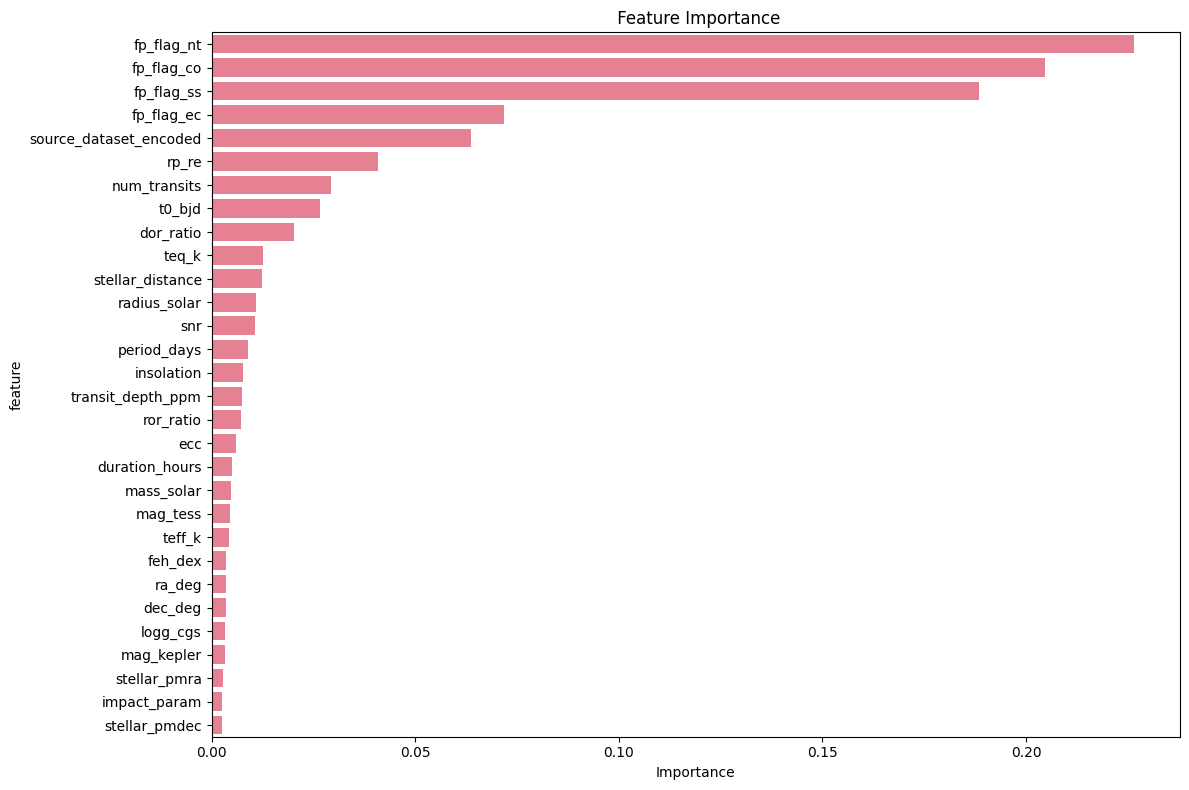

In [76]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📈 FEATURE IMPORTANCE")
print(feature_importance)
# Tüm feature importance değerlerini yazdır
print("\nTÜM FEATURE IMPORTANCE DEĞERLERİ:")
print(feature_importance)

# Feature importance plot
plt.figure(figsize=(12, 8))
top_features = feature_importance
sns.barplot(data=top_features, x='importance', y='feature')
plt.title(' Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 6. Candidate Prediction


In [ ]:

print("🎯 CANDIDATE TAHMİNLERİ")
candidate_predictions = model.predict(X_candidates)
candidate_probabilities = model.predict_proba(X_candidates)[:, 1]

print(f"Candidate tahmin sayısı: {len(candidate_predictions)}")
print(f"\nCandidate tahmin dağılımı:")
print(pd.Series(candidate_predictions).value_counts())
print(f"\nCandidate tahmin dağılımı yüzdesi:")
print(pd.Series(candidate_predictions).value_counts(normalize=True) * 100)


🎯 CANDIDATE TAHMİNLERİ
Candidate tahmin sayısı: 8671

Candidate tahmin dağılımı:
0    4595
1    4076
Name: count, dtype: int64

Candidate tahmin dağılımı yüzdesi:
0    52.992734
1    47.007266
Name: proportion, dtype: float64


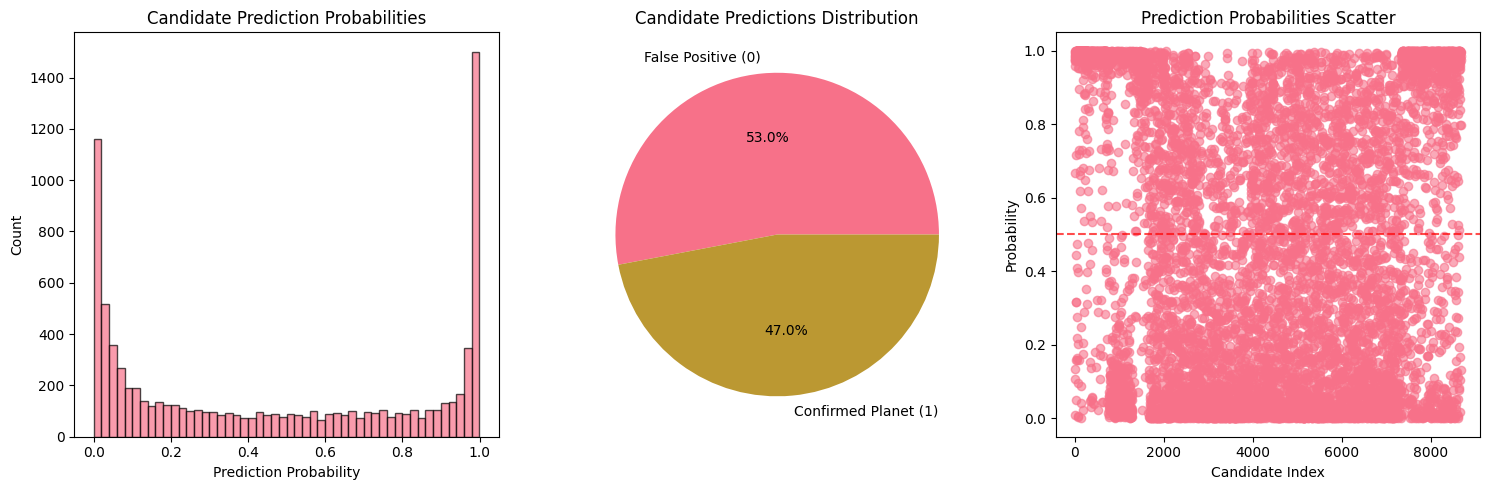

In [ ]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(candidate_probabilities, bins=50, alpha=0.7, edgecolor='black')
plt.title('Candidate Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
prediction_counts = pd.Series(candidate_predictions).value_counts()
plt.pie(prediction_counts.values, labels=['False Positive (0)', 'Confirmed Planet (1)'], autopct='%1.1f%%')
plt.title('Candidate Predictions Distribution')

plt.subplot(1, 3, 3)
plt.scatter(range(len(candidate_probabilities)), candidate_probabilities, alpha=0.6)
plt.title('Prediction Probabilities Scatter')
plt.xlabel('Candidate Index')
plt.ylabel('Probability')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 7. Final CSV Creation - Training + Candidate (With Predicted Labels)


In [ ]:
# Final CSV: Training data + Candidate data (with predicted labels)
print("FINAL CSV CREATION")

# 1. Prepare training data
training_final = train_df.copy()
training_final['final_label'] = training_final['label']  # Original labels
training_final['is_predicted'] = 0  # Training data not predicted
training_final['prediction_probability'] = np.nan  # Empty for training

print(f"Training data shape: {training_final.shape}")
print(f"Training label distribution:")
print(training_final['final_label'].value_counts())

# 2. Prepare candidate data (with predicted labels)
candidate_final = candidate_df.copy()
candidate_final['final_label'] = candidate_predictions  # Predicted label (0 or 1)
candidate_final['is_predicted'] = 1  # Candidate data is predicted
candidate_final['prediction_probability'] = candidate_probabilities  # Prediction probability

# Also preserve original label
candidate_final['original_label'] = candidate_final['label']
candidate_final['label'] = candidate_final['final_label']  # Update label with prediction

print(f"\nCandidate data shape: {candidate_final.shape}")
print(f"Candidate predicted label distribution:")
print(candidate_final['final_label'].value_counts())


📊 NİHAİ CSV OLUŞTURMA
Training data boyutu: (12193, 37)
Training label dağılımı:
final_label
0    6449
1    5744
Name: count, dtype: int64

Candidate data boyutu: (8671, 38)
Candidate tahmin edilen label dağılımı:
final_label
0    4595
1    4076
Name: count, dtype: int64


In [ ]:
# 3. Merge Training and Candidate
print("\n🔗 DATA MERGE")

# Align columns
# Add missing column for training if needed
if 'original_label' not in training_final.columns:
    training_final['original_label'] = training_final['label']

# Ensure both dataframes share the same columns
common_columns = list(set(training_final.columns) & set(candidate_final.columns))
print(f"Common column count: {len(common_columns)}")

# Concatenate using common columns
final_dataset = pd.concat([
    training_final[common_columns],
    candidate_final[common_columns]
], ignore_index=True)

print(f"\n✅ Final dataset shape: {final_dataset.shape}")
print(f"Total rows: {len(final_dataset)}")
print(f"\nFinal label distribution:")
print(final_dataset['final_label'].value_counts())
print(f"\nFinal label distribution (%):")
print(final_dataset['final_label'].value_counts(normalize=True) * 100)



🔗 VERİ BİRLEŞTİRME
Ortak kolon sayısı: 38

✅ Nihai dataset boyutu: (20864, 38)
Toplam veri sayısı: 20864

Nihai label dağılımı:
final_label
0    11044
1     9820
Name: count, dtype: int64

Nihai label dağılımı yüzdesi:
final_label
0    52.933282
1    47.066718
Name: proportion, dtype: float64


In [ ]:
# 4. Veri kalitesi kontrolü ve özet
print("\n🔍 NİHAİ VERİ KALİTE KONTROLÜ")


print(f"İs_predicted dağılımı:")
print(final_dataset['is_predicted'].value_counts())
print(f"\n- Training data (is_predicted=0): {(final_dataset['is_predicted'] == 0).sum()}")
print(f"- Predicted data (is_predicted=1): {(final_dataset['is_predicted'] == 1).sum()}")

print(f"\nSource dataset dağılımı:")
print(final_dataset['source_dataset'].value_counts())


print(f"\n📊 DETAYLI LABEL DAĞILIMI")
print(f"False Positive (0): {(final_dataset['final_label'] == 0).sum()}")
print(f"Confirmed Planet (1): {(final_dataset['final_label'] == 1).sum()}")

predicted_candidates = final_dataset[final_dataset['is_predicted'] == 1]
print(f"\n🎯 TAHMİN EDİLEN CANDIDATE'LAR")
print(f"Toplam tahmin edilen: {len(predicted_candidates)}")
print(f"Tahmin edilen False Positive (0): {(predicted_candidates['final_label'] == 0).sum()}")
print(f"Tahmin edilen Confirmed Planet (1): {(predicted_candidates['final_label'] == 1).sum()}")



🔍 NİHAİ VERİ KALİTE KONTROLÜ
İs_predicted dağılımı:
is_predicted
0    12193
1     8671
Name: count, dtype: int64

- Training data (is_predicted=0): 12193
- Predicted data (is_predicted=1): 8671

Source dataset dağılımı:
source_dataset
kepler    9242
tess      7661
k2        3961
Name: count, dtype: int64

📊 DETAYLI LABEL DAĞILIMI
False Positive (0): 11044
Confirmed Planet (1): 9820

🎯 TAHMİN EDİLEN CANDIDATE'LAR
Toplam tahmin edilen: 8671
Tahmin edilen False Positive (0): 4595
Tahmin edilen Confirmed Planet (1): 4076


In [ ]:
# 5. Final CSV save
print("\n💾 NİHAİ CSV KAYDETME")

final_csv_filename = 'unified_exoplanet_dataset_with_predictions.csv'
final_dataset.to_csv(final_csv_filename, index=False)

print(f" Nihai CSV '{final_csv_filename}' dosyasına kaydedildi!")
print(f"\n NİHAİ DATASET ÖZETİ")
print(f"Toplam veri sayısı: {len(final_dataset):,}")
print(f"Toplam kolon sayısı: {len(final_dataset.columns)}")
print(f"\nVeri dağılımı:")
print(f"  - Training data: {(final_dataset['is_predicted'] == 0).sum():,}")
print(f"  - Predicted candidate: {(final_dataset['is_predicted'] == 1).sum():,}")
print(f"\nLabel dağılımı:")
print(f"  - False Positive (0): {(final_dataset['final_label'] == 0).sum():,} ({(final_dataset['final_label'] == 0).sum() / len(final_dataset) * 100:.2f}%)")
print(f"  - Confirmed Planet (1): {(final_dataset['final_label'] == 1).sum():,} ({(final_dataset['final_label'] == 1).sum() / len(final_dataset) * 100:.2f}%)")

print(f"\n📏 BOYUT KONTROLÜ")
print(f"Hedef: ~20k veri")
print(f"Gerçek: {len(final_dataset):,} veri")
if len(final_dataset) >= 19000 and len(final_dataset) <= 21000:
    print(" Hedef boyuta ulaşıldı!")
else:
    print(f"  Hedef boyuttan {abs(20000 - len(final_dataset)):,} fark var")



💾 NİHAİ CSV KAYDETME
✅ Nihai CSV 'unified_exoplanet_dataset_with_predictions.csv' dosyasına kaydedildi!

📊 NİHAİ DATASET ÖZETİ
Toplam veri sayısı: 20,864
Toplam kolon sayısı: 38

Veri dağılımı:
  - Training data: 12,193
  - Predicted candidate: 8,671

Label dağılımı:
  - False Positive (0): 11,044 (52.93%)
  - Confirmed Planet (1): 9,820 (47.07%)

📏 BOYUT KONTROLÜ
Hedef: ~20k veri
Gerçek: 20,864 veri
✅ Hedef boyuta ulaşıldı!



📈 NİHAİ DATASET GÖRSELLEŞTİRME


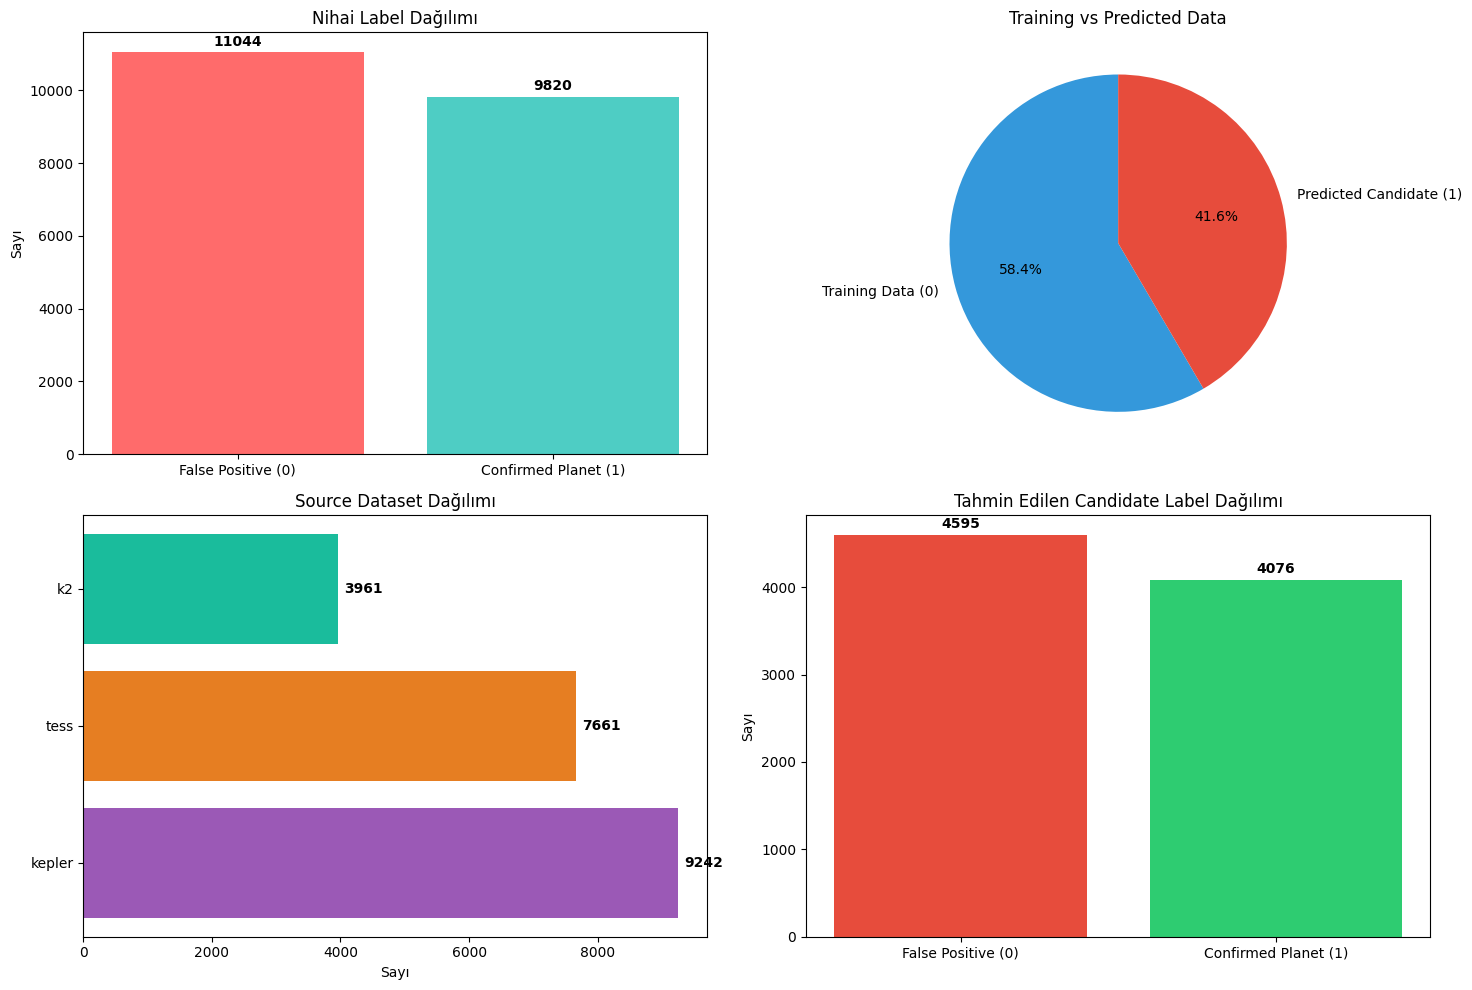

✅ Görselleştirme tamamlandı!


In [ ]:
# 6. Visualization - Final dataset
print("\n📈 NİHAİ DATASET GÖRSELLEŞTİRME")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Label 
ax1 = axes[0, 0]
label_counts = final_dataset['final_label'].value_counts()
ax1.bar(['False Positive (0)', 'Confirmed Planet (1)'], label_counts.values, color=['#ff6b6b', '#4ecdc4'])
ax1.set_title('Nihai Label Dağılımı')
ax1.set_ylabel('Sayı')
for i, v in enumerate(label_counts.values):
    ax1.text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Training vs Predicted
ax2 = axes[0, 1]
predicted_counts = final_dataset['is_predicted'].value_counts()
labels = ['Training Data (0)', 'Predicted Candidate (1)']
colors = ['#3498db', '#e74c3c']
ax2.pie(predicted_counts.values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Training vs Predicted Data')

# 3. Source dataset
ax3 = axes[1, 0]
source_counts = final_dataset['source_dataset'].value_counts()
ax3.barh(source_counts.index, source_counts.values, color=['#9b59b6', '#e67e22', '#1abc9c'])
ax3.set_title('Source Dataset Dağılımı')
ax3.set_xlabel('Sayı')
for i, v in enumerate(source_counts.values):
    ax3.text(v + 100, i, str(v), va='center', fontweight='bold')

# 4. Predicted candidate label 
ax4 = axes[1, 1]
pred_label_counts = predicted_candidates['final_label'].value_counts()
ax4.bar(['False Positive (0)', 'Confirmed Planet (1)'], pred_label_counts.values, color=['#e74c3c', '#2ecc71'])
ax4.set_title('Tahmin Edilen Candidate Label Dağılımı')
ax4.set_ylabel('Sayı')
for i, v in enumerate(pred_label_counts.values):
    ax4.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Görselleştirme tamamlandı!")


In [ ]:
# 7. Summary report
print("\n" + "="*70)
print("🎉 NİHAİ DATASET OLUŞTURMA TAMAMLANDI!")
print("="*70)

print(f"\n📁 DOSYA BİLGİSİ:")
print(f"Dosya adı: {final_csv_filename}")

print(f"\n📊 DATASET İSTATİSTİKLERİ:")
print(f"Toplam veri: {len(final_dataset):,} satır")
print(f"Toplam feature: {len(final_dataset.columns)} kolon")

print(f"\n🔢 VERİ KAYNAKLARI:")
training_count = (final_dataset['is_predicted'] == 0).sum()
predicted_count = (final_dataset['is_predicted'] == 1).sum()
print(f"Training data (orijinal label): {training_count:,} ({training_count/len(final_dataset)*100:.1f}%)")
print(f"Predicted candidate (tahmin edilen): {predicted_count:,} ({predicted_count/len(final_dataset)*100:.1f}%)")

print(f"\n🏷️  LABEL DAĞILIMI:")
fp_count = (final_dataset['final_label'] == 0).sum()
cp_count = (final_dataset['final_label'] == 1).sum()
print(f"False Positive (0): {fp_count:,} ({fp_count/len(final_dataset)*100:.1f}%)")
print(f"Confirmed Planet (1): {cp_count:,} ({cp_count/len(final_dataset)*100:.1f}%)")

print(f"\n🔭 SOURCE DATASET:")
for source, count in final_dataset['source_dataset'].value_counts().items():
    print(f"{source.capitalize()}: {count:,} ({count/len(final_dataset)*100:.1f}%)")

print(f"\n✅ Dataset başarıyla oluşturuldu ve kaydedildi!")
print("="*70)



🎉 NİHAİ DATASET OLUŞTURMA TAMAMLANDI!

📁 DOSYA BİLGİSİ:
Dosya adı: unified_exoplanet_dataset_with_predictions.csv

📊 DATASET İSTATİSTİKLERİ:
Toplam veri: 20,864 satır
Toplam feature: 38 kolon

🔢 VERİ KAYNAKLARI:
Training data (orijinal label): 12,193 (58.4%)
Predicted candidate (tahmin edilen): 8,671 (41.6%)

🏷️  LABEL DAĞILIMI:
False Positive (0): 11,044 (52.9%)
Confirmed Planet (1): 9,820 (47.1%)

🔭 SOURCE DATASET:
Kepler: 9,242 (44.3%)
Tess: 7,661 (36.7%)
K2: 3,961 (19.0%)

✅ Dataset başarıyla oluşturuldu ve kaydedildi!


In [ ]:

print("\n👀 NİHAİ DATASET ÖNİZLEME")

print("\n📋 İLK 10 SATIR:")
display_columns = ['star_id', 'planet_id', 'source_dataset', 'final_label', 'is_predicted', 'prediction_probability']
print(final_dataset[display_columns].head(10))

print("\n📋 SON 10 SATIR:")
print(final_dataset[display_columns].tail(10))

print("\n📋 KOLON İSİMLERİ:")
print(f"Toplam {len(final_dataset.columns)} kolon:")
for i, col in enumerate(final_dataset.columns, 1):
    print(f"{i:2d}. {col}")

print("\n🎯 ÖNEMLİ KOLONLAR:")
print("- final_label: Nihai sınıf (0=False Positive, 1=Confirmed Planet)")
print("- is_predicted: Tahmin edildi mi? (0=Training, 1=Predicted)")
print("- prediction_probability: Tahmin olasılığı (sadece predicted için)")
print("- original_label: Orijinal label (sadece candidate için)")



👀 NİHAİ DATASET ÖNİZLEME

📋 İLK 10 SATIR:
    star_id  planet_id source_dataset  final_label  is_predicted  \
0  10797460  K00752.01         kepler            1             0   
1  10797460  K00752.02         kepler            1             0   
2  10848459  K00754.01         kepler            0             0   
3  10854555  K00755.01         kepler            1             0   
4  10872983  K00756.01         kepler            1             0   
5  10872983  K00756.02         kepler            1             0   
6  10872983  K00756.03         kepler            1             0   
7   6721123  K00114.01         kepler            0             0   
8  10910878  K00757.01         kepler            1             0   
9  11446443  K00001.01         kepler            1             0   

   prediction_probability  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6           